In [1]:
%matplotlib inline
from run_dnerf import config_parser, create_nerf
import torch
from load_blender import pose_spherical
from run_dnerf import render_path
from run_dnerf_helpers import to8b
import numpy as np
import matplotlib.pyplot as plt
import mcubes
import trimesh

In [10]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get config file
config_file = "configs/old_llff_yong_kati.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
# render_kwargs_test.update({'near' : 2., 'far' : 6.})
render_kwargs_test.update({'near' : 1.200000035762787, 'far' : 143.82839965820312}) 

NeRF type selected: direct_temporal
Found ckpts ['./logs/yong_kati_test/100000.tar', './logs/yong_kati_test/200000.tar', './logs/yong_kati_test/300000.tar', './logs/yong_kati_test/400000.tar', './logs/yong_kati_test/500000.tar', './logs/yong_kati_test/600000.tar', './logs/yong_kati_test/700000.tar']
Reloading from ./logs/yong_kati_test/700000.tar


## Generate Debug Frame

In [11]:
def generate_img(time):
    render_poses = torch.unsqueeze(pose_spherical(180, -20, 4.0), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


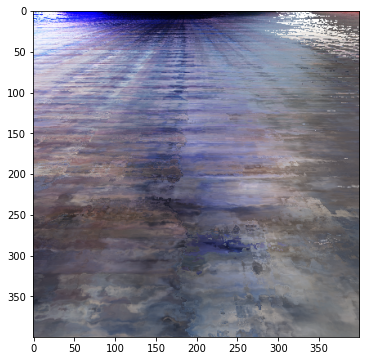

In [12]:
# genearte
time = .5  # time in [0,1]
img = generate_img(time)

# display
plt.figure(2, figsize=(20,6))
plt.imshow(img)
plt.show()

## Reconstruct

In [7]:
N = 256
min_rec, max_rec = -1.2, 1.2
t = np.linspace(min_rec, max_rec, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
sh = query_pts.shape
pts = torch.Tensor(query_pts.reshape([-1,3]))


def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret

def reconstruct(points, time):
    net_fn = render_kwargs_test['network_query_fn']
    fn = lambda i0, i1 : net_fn(points[i0:i1,None,:], viewdirs=torch.zeros_like(points[i0:i1]), ts=torch.ones_like(points[i0:i1])[:,0:1]*time, network_fn=render_kwargs_test['network_fn'])
    chunk = 1024*64
    raw = np.concatenate([fn(i, i+chunk)[0].cpu().numpy() for i in range(0, points.shape[0], chunk)], 0)
    raw = np.reshape(raw, list(sh[:-1]) + [-1])
    sigma = np.maximum(raw[...,-1], 0.)
    return sigma
    
with torch.no_grad():
    sigma = reconstruct(pts, time)

In [8]:
# reconstruct
threshold = 40  # this is just a randomly found threshold
vertices, triangles = mcubes.marching_cubes(sigma, threshold)

# display
mesh = trimesh.Trimesh(vertices / N * (max_rec - min_rec) + min_rec , triangles)
mesh = trimesh.smoothing.filter_laplacian(mesh, iterations=3)
mesh.show()

ValueError: need at least one array to concatenate